# Hodoscope analysis

In [1]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import hodoscope_functions as hd

from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import norm, moyal, binned_statistic
from scipy.signal import find_peaks

#pd.options.display.max_columns = 500
#pd.options.display.max_rows = 100000

# 1. Gamma peak analysis

In [2]:
ntuple_dir = "/Users/jrenner/local/data/beamtest/ntuple_files/"
ntuple_pd_dir = "/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/"

In [3]:
runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765]
rmomenta = [460, 500, 600, 700, 800, 900, 1000, 1200, 500, 600, 700, 800, 1000, 900, 1200, 800]

## 1a. Multi-run analysis

In [ ]:
# Run the gamma peak analysis for all runs.
all_fit_results, all_fit_arrays = [], []
all_ntot_evts, all_ntot_spills, all_ntot_tagged_evts = [], [], []
for rnum, pbeam in zip(runs, rmomenta):
    
    print("Processing run",rnum,"...")
    df_dict = hd.read_dataframes_from_csv("/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/run000{}".format(rnum))
    
    # Run the timing analysis (event selection).
    final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.timing_analysis(df_dict, pb_timing_range, tof0_timing_range, tof0_charge_range, 
                    tof1_timing_range, tof1_charge_range, t2_timing_range, t2_charge_range,
                    act0_timing_range, act0_charge_range, act1_timing_range, act1_charge_range,
                    act3_timing_range, hd_timing_ranges, hd_charge_ranges)
    
    # Save the results of the gamma peak fits for plotting later.
    fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,0.8])
    
    all_fit_results.append(fit_results)
    all_fit_arrays.append(fit_arrays)
    all_ntot_evts.append(ntot_evts)
    all_ntot_spills.append(ntot_spills)
    all_ntot_tagged_evts.append(ntot_tagged_evts)
    
all_fit_results = np.array(all_fit_results)
all_fit_arrays = np.array(all_fit_arrays)

In [ ]:
print(len(final_df[final_df.total_hits == 1]))
print(ntot_tagged_evts)

#### Summary of data (*tbl.data*)

In [ ]:
# Print table of results.
for rnum,p,nevts,nspills in zip(runs, rmomenta, all_ntot_evts, all_ntot_spills):
    print(f"{rnum} & {p} & {nevts} & {nspills} & \\\\")

In [ ]:
print(all_ntot_tagged_evts/np.array(all_ntot_evts))

#### Tagged events per spill

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

all_ntot_spills = np.array(all_ntot_spills)
all_ntot_tagged_evts = np.array(all_ntot_tagged_evts)

ax.plot(rmomenta,all_ntot_tagged_evts/all_ntot_spills,'o',color='black')
ax.set_ylim([0,400])
ax.set_xlabel("Beam momentum (MeV/c)",fontsize=14)
ax.set_ylabel("Tagged photons/spill",fontsize=14)
plt.savefig("tagged_evts_per_spill.pdf",bbox_inches='tight')

#### Lead glass calibration plot (*fig.LG_calibration*)

In [ ]:
# Plot all gamma peak means and fit lines on the same plot.
elec_hit_momenta_values = [v for v in hd.elec_hit_momenta.values()]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
momentum_color = {460: "red", 500: "orange", 600: "yellow", 700: "green", 
                  800: "blue", 900: "violet", 1000: "gray", 1100: "brown", 1200: "black"}
momentum_plt   = {460: False, 500: False, 600: False, 700: False,
                  800: False, 900: False, 1000: False, 1100: False, 1200: False}

all_e_gamma_expected = []
for run_momentum, fit_array in zip(rmomenta,all_fit_arrays):
    
    # Get the fit means and errors for this run.
    fit_means, fit_smeans = fit_array[0], fit_array[1]

    e_gamma_expected = [run_momentum - mval*1000 for mval in elec_hit_momenta_values[::-1]]
    all_e_gamma_expected.append(e_gamma_expected)
    
    if(not momentum_plt[run_momentum]):
        ax.errorbar(e_gamma_expected, fit_means, yerr=fit_smeans, fmt='.', 
                    color=momentum_color[run_momentum], label=f"p = {run_momentum} MeV/c")
        momentum_plt[run_momentum] = True
    else:
        ax.errorbar(e_gamma_expected, fit_means, yerr=fit_smeans, fmt='.', 
                    color=momentum_color[run_momentum])
        
# Fit a line to all results at once.
all_fit_means = all_fit_arrays[:,0,:].flatten()
all_fit_smeans = all_fit_arrays[:,1,:].flatten()
all_e_gamma_expected = np.array(all_e_gamma_expected).flatten()

p0 = [(np.max(all_e_gamma_expected) - np.min(all_e_gamma_expected))/(np.max(all_fit_means) - np.min(all_fit_means)),all_e_gamma_expected[0]]
popt, pcov = curve_fit(hd.line, all_e_gamma_expected, all_fit_means, p0, sigma=all_fit_smeans)
x = np.linspace(50, 1120, 1000)
y = hd.line(x, *popt)
perr = np.sqrt(np.diag(pcov))
#ax.plot(x, y, label='C = $({:.2f} \pm {:.2f}) x 10^{{-4}} \cdot $p + $({:.3f} \pm {:.4f})$'.format(popt[0]*10000,perr[0]*10000,popt[1],perr[1]), color='red', alpha=0.8, linewidth=3, linestyle=':')
ax.plot(x, y, color='black', alpha=0.8, linewidth=1, linestyle='-')
ax.annotate("---- C = $({:.2f} \pm {:.2f}) x 10^{{-4}} \cdot $E + $({:.3f} \pm {:.4f})$".format(popt[0]*10000,perr[0]*10000,popt[1],perr[1]), xy=(500, 0.10), xytext=(200, 0.01), fontsize=14, fontweight='bold', color='black')

ax.legend(title="Beam momentum",title_fontsize=12,fontsize=11)
ax.set_ylabel('Lead glass charge [arbitrary units]',fontsize=14)
ax.set_xlabel('Expected energy [MeV]',fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.savefig("LG_calibration.pdf", bbox_inches='tight')

In [ ]:
# Plot the slope and intercept of the calibration curve vs. momentum
mvals = all_fit_results[:,0]
merr = all_fit_results[:,1]
bvals = all_fit_results[:,2]
berr = all_fit_results[:,3]
fvals = all_fit_results[:,4]
ferr = all_fit_results[:,5]
cvals = all_fit_results[:,6]
cerr = all_fit_results[:,7]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
flat_axes = axes.ravel()

flat_axes[0].errorbar(rmomenta,mvals*10000,yerr=merr*10000,fmt='o')
flat_axes[0].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[0].set_ylabel('Slope $x 10^{-4}$ (LG charge)/MeV',fontsize=20)
flat_axes[0].tick_params(axis="x", labelsize=14)
flat_axes[0].tick_params(axis="y", labelsize=14)

flat_axes[1].errorbar(rmomenta,bvals,yerr=berr,fmt='o')
flat_axes[1].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[1].set_ylabel('Intercept (LG charge)',fontsize=20)
flat_axes[1].tick_params(axis="x", labelsize=14)
flat_axes[1].tick_params(axis="y", labelsize=14)

flat_axes[2].errorbar(rmomenta,fvals,yerr=ferr,fmt='o')
flat_axes[2].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[2].set_ylabel('Parameter F',fontsize=20)
flat_axes[2].tick_params(axis="x", labelsize=14)
flat_axes[2].tick_params(axis="y", labelsize=14)

flat_axes[3].errorbar(rmomenta,cvals,yerr=cerr,fmt='o')
flat_axes[3].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[3].set_ylabel('Parameter C',fontsize=20)
flat_axes[3].tick_params(axis="x", labelsize=14)
flat_axes[3].tick_params(axis="y", labelsize=14)

## 1b. Single-run analysis

In [4]:
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

In [5]:
# Read in all dataframes from a given run
rnum = 735
low_radiation = False
pbeam = 800
tail_threshold = 2.6
df_dict = hd.read_dataframes_from_csv(f"{ntuple_pd_dir}run000{rnum}_win")
df_dict.keys()

dict_keys(['EventInfo', 'ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

In [6]:
df_dict['HD0'].keys()

Index(['event', 'iPeak', 'nPeaks', 'timeStamp', 'triggerTime', 'Pedestal',
       'PedestalSigma', 'PeakVoltage', 'PeakTime', 'SignalTime', 'IntCharge',
       'SignalTimeCorrected', 'SignalTimeMatchedTOF0', 'SignalTimeMatchedTOF1',
       'IntPE', 'MaxVoltage', 'WholeWaveformInt', 'WholeWaveformIntPE',
       'nWindowPeaks', 'WindowIntCharge', 'WindowIntPE', 'WindowWidth',
       'WindowLowerTime', 'WindowUpperTime', 'WindowCentralTime',
       'WindowCentralTimeCorrected', 'spillNumber'],
      dtype='object')

In [7]:
def timing_plot(detname, pk_times, t_range, nbins, normed=False, logscale=False):

    # Create the plot
    hist, bin_edges = np.histogram(pk_times, bins=nbins, range=t_range, density=normed)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Gaussian fit
    fit_start = 0
    fit_end = -1
    initial_params = [np.max(hist), np.mean(pk_times), np.std(pk_times)]
    print(f"Initial params: {initial_params}")
    popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
    perr = np.sqrt(np.diag(pcov))
    fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)

    # Plot the fit peak
    fig = plt.figure(figsize=(8,5))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
    plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
    plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)

    # Prepare the legend.
    lbl1 = f"{detname}"
    lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
    lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
    legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                       Line2D([0], [0], color='none', lw=0, label=lbl2),
                       Line2D([0], [0], color='none', lw=0, label=lbl3)]
    leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
    for i, text in enumerate(leg.get_texts()):
        if i == 0:
            text.set_weight('bold')
        text.set_horizontalalignment('right')

    plt.xlabel("SignalTimeCorrected",fontsize=18)
    plt.ylabel("Counts/bin",fontsize=18)
    plt.gca().tick_params(axis="x", labelsize=14)
    plt.gca().tick_params(axis="y", labelsize=14)
    if(logscale): plt.yscale('log')

Initial params: [3506, 71.7753998691183, 10.700430837235169]


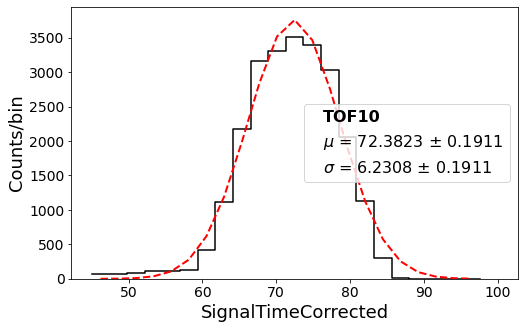

In [8]:
# Make timing plots for all detectors using the SignalTimeCorrected branch
# Consider the time for all detectors relative to TOF10
pk_times = df_dict['TOF10']['WindowCentralTimeCorrected']
t_range = [45,100]
nbins = 23
normed = False
timing_plot('TOF10',pk_times,t_range,nbins)

In [9]:
# Cut on events with peaks in TOF10 at the selected values
df_T1sel = hd.filter_range('TOF10',df_dict['TOF10'],'WindowCentralTimeCorrected',[60,86],drop=True,debug=True)

TOF10 filter passed 23552 of 24982 with 536 duplicates
--> returning 23016 events


[ACT0L] before selection 24041
[ACT0L] selecting out 403 events to get 396
[ACT0L] selecting out 4157 events to get 4088
[ACT0R] before selection 24749
[ACT0R] selecting out 403 events to get 403
[ACT0R] selecting out 4157 events to get 4136
[ACT1L] before selection 19887
[ACT1L] selecting out 403 events to get 334
[ACT1L] selecting out 4157 events to get 3655
[ACT1R] before selection 23921
[ACT1R] selecting out 403 events to get 400
[ACT1R] selecting out 4157 events to get 4079
[ACT3L] before selection 1106
[ACT3L] selecting out 403 events to get 27
[ACT3L] selecting out 4157 events to get 176
[ACT3R] before selection 1455
[ACT3R] selecting out 403 events to get 43
[ACT3R] selecting out 4157 events to get 209
[TOF00] before selection 24813
[TOF00] selecting out 403 events to get 403
[TOF00] selecting out 4157 events to get 4155
[TOF01] before selection 24969
[TOF01] selecting out 403 events to get 403
[TOF01] selecting out 4157 events to get 4157
[TOF02] before selection 24863
[TOF02]

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[HD2] before selection 355
[HD2] selecting out 403 events to get 2
[HD2] selecting out 4157 events to get 0
[HD3] before selection 485
[HD3] selecting out 403 events to get 1
[HD3] selecting out 4157 events to get 1
[HD4] before selection 542
[HD4] selecting out 403 events to get 0
[HD4] selecting out 4157 events to get 0
[HD5] before selection 805
[HD5] selecting out 403 events to get 2
[HD5] selecting out 4157 events to get 0
[HD6] before selection 981
[HD6] selecting out 403 events to get 0
[HD6] selecting out 4157 events to get 1
[HD7] before selection 1116
[HD7] selecting out 403 events to get 0
[HD7] selecting out 4157 events to get 0
[HD8] before selection 1405
[HD8] selecting out 403 events to get 0
[HD8] selecting out 4157 events to get 0
[HD9] before selection 1823
[HD9] selecting out 403 events to get 1
[HD9] selecting out 4157 events to get 1
[HD10] before selection 2262
[HD10] selecting out 403 events to get 1
[HD10] selecting out 4157 events to get 1
[HD11] before selecti

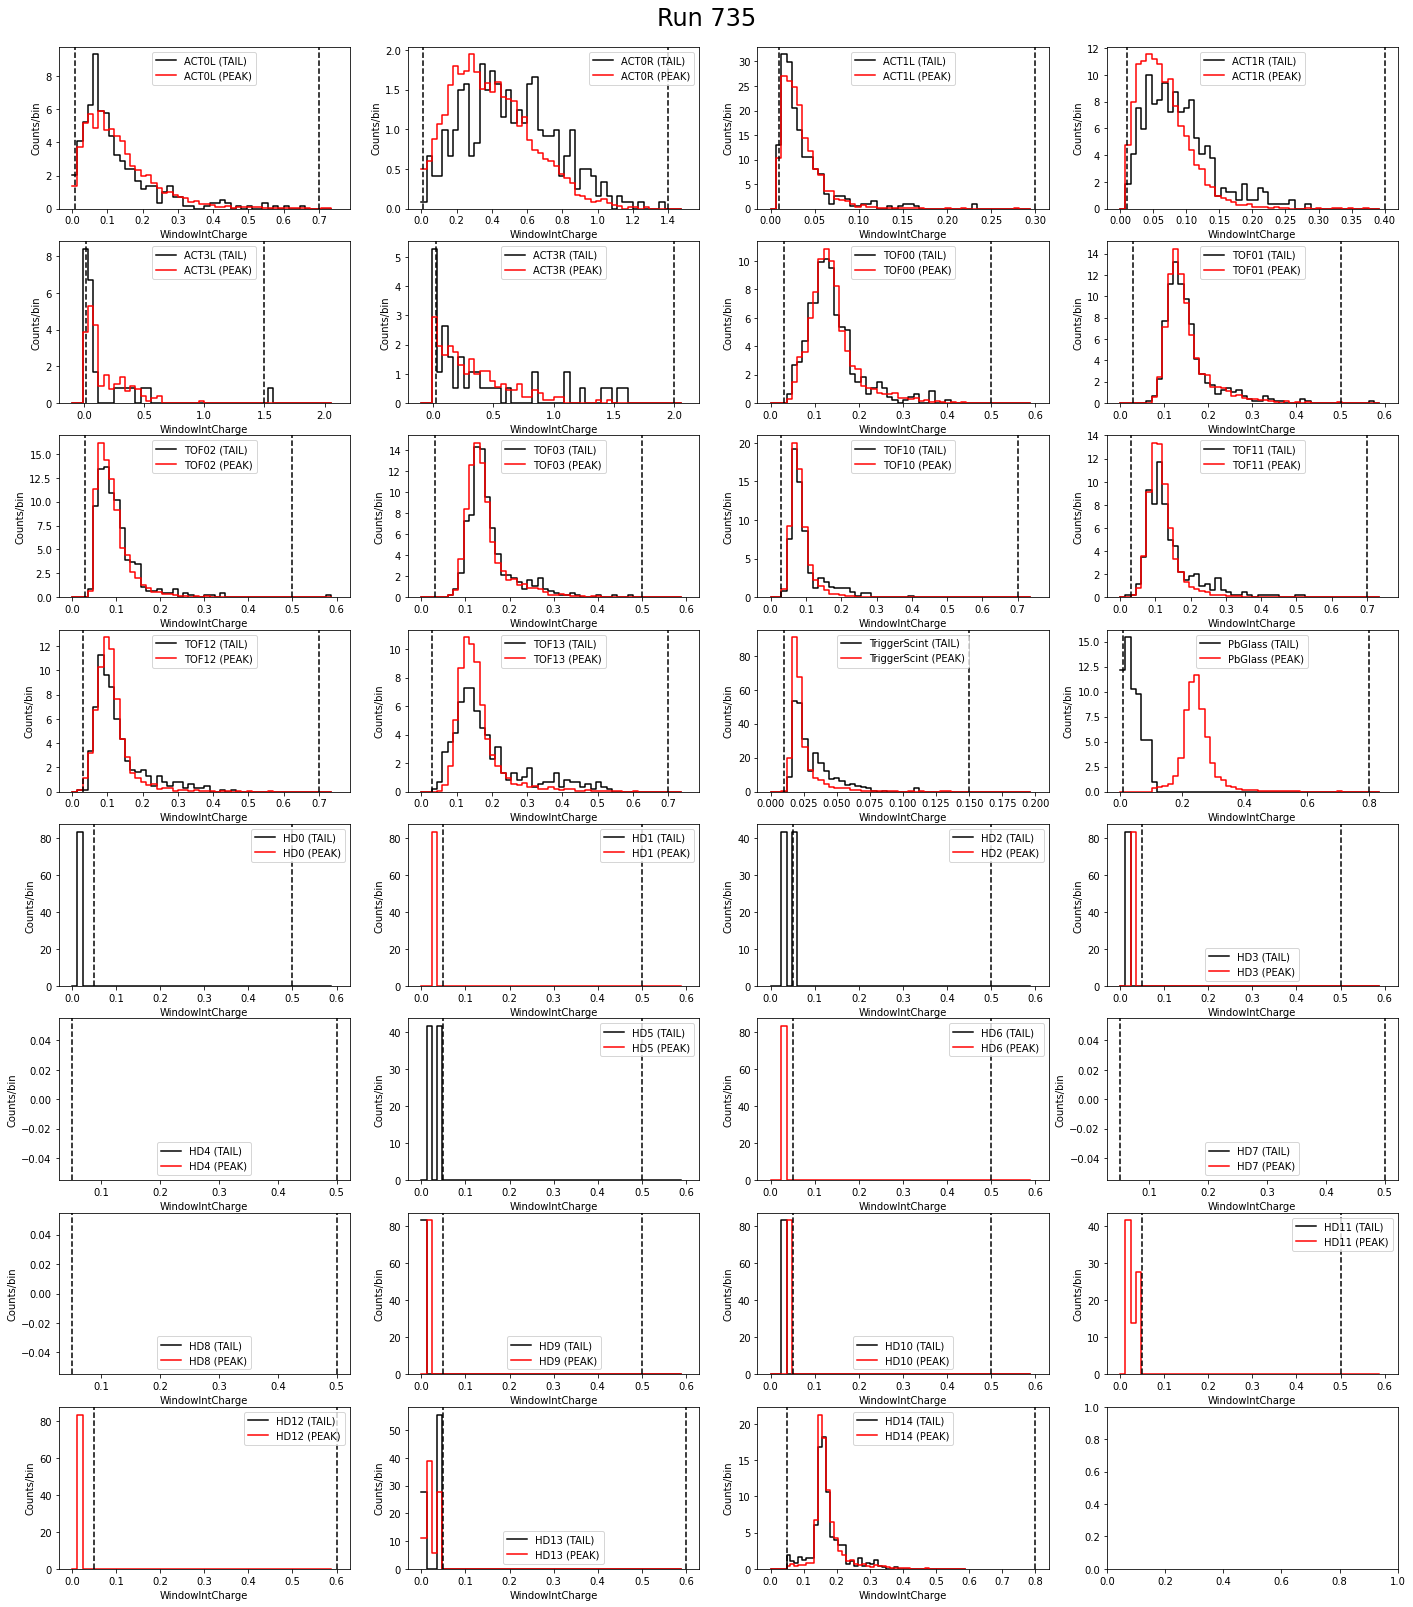

In [19]:
from hodoscope_constants import chg_cuts_tight, chg_cuts_wide, chg_ranges_wide

# Assign the charge cuts
chg_cuts = chg_cuts_wide
chg_range = chg_ranges_wide

# Plot the charge cuts
evt_list = evt_list_TAIL
lbl = 'TAIL'
evt_list_2 = evt_list_PEAK
lbl_2 = 'PEAK'
select_nonzero_peaks = True
windowInt = True
quantity = 'WindowIntCharge'
logscale = False
nbins = 50
normed = True

# Create a grid of 8 rows x 4 columns
fig, axes = plt.subplots(8, 4, figsize=(24, 28))
flat_axes = axes.ravel()

fig.suptitle(f'Run {rnum}', fontsize=24, y=0.9)

# Iterate based on the custom order
for key, ax in zip(hd.custom_order, flat_axes):
    df = df_dict[key]
    
    # Select only non-zero peaks if specified.
    if(select_nonzero_peaks):
        if(windowInt):
            df_select = df[df['nWindowPeaks'] > 0]
        else:
            df_select = df[df['nPeaks'] > 0]
    # Otherwise, this quantity is event-wide: only keep 1 entry for each event.
    else:
        df_select = df.drop_duplicates(subset=['event'], keep='first')

    # Place a cut if we're plotting PeakVoltage or IntCharge.
    #if((key[0:2] == 'HD' or key == 'PbGlass') and (quantity == 'IntCharge' or quantity == 'PeakVoltage' or quantity == 'MaxVoltage' or quantity == 'WindowIntCharge' or quantity == 'WholeWaveformInt' or quantity == 'WindowIntPE')):
    if(quantity == 'IntCharge' or quantity == 'PeakVoltage' or quantity == 'MaxVoltage' or quantity == 'WindowIntCharge' or quantity == 'WholeWaveformInt' or quantity == 'WindowIntPE'):
        df_select = df_select[df_select[quantity] > 1e-2]

    # Cut on the selected events if an event list is provided.
    if(not(evt_list is None)):
        print(f"[{key}] before selection {len(df_select)}")
        
        df_select_1 = df_select[df_select['event'].isin(evt_list)]
        print(f"[{key}] selecting out {len(evt_list)} events to get {len(df_select_1)}")
        
        if(not(evt_list_2 is None)):
            df_select_2 = df_select[df_select['event'].isin(evt_list_2)]
            print(f"[{key}] selecting out {len(evt_list_2)} events to get {len(df_select_2)}")
    else:
        df_select_1 = df_select

    # Plot histogram for the current signal on its corresponding axis
    hist_charge, bin_edges_charge = np.histogram(df_select_1[quantity], bins=nbins, density=normed, range=chg_range[key])
    bin_centers_charge = (bin_edges_charge[:-1] + bin_edges_charge[1:]) / 2
    ax.bar(bin_edges_charge[:-1], hist_charge, width=np.diff(bin_edges_charge)[0], align='edge', color='white')
    ax.plot(bin_edges_charge[:-1], hist_charge, color='black', drawstyle='steps-post', label=f"{key} ({lbl})")
    
    if(not(evt_list_2 is None)):
        hist_charge_2, bin_edges_charge_2 = np.histogram(df_select_2[quantity], bins=nbins, density=normed, range=chg_range[key])
        bin_centers_charge_2 = (bin_edges_charge_2[:-1] + bin_edges_charge_2[1:]) / 2
        ax.bar(bin_edges_charge_2[:-1], hist_charge_2, width=np.diff(bin_edges_charge_2)[0], align='edge', color='white')
        ax.plot(bin_edges_charge_2[:-1], hist_charge_2, color='red', drawstyle='steps-post', label=f"{key} ({lbl_2})")

    #n, bins, patches = ax.hist(df_select[quantity], bins=nbins, edgecolor='black', alpha=0.7, label=key)  # capture output to use in legend
    ax.axvline(chg_cuts[key][0],color='black',linestyle='--')
    ax.axvline(chg_cuts[key][1],color='black',linestyle='--')
    #ax.set_title(key)
    ax.set_xlabel(quantity)
    ax.set_ylabel('Counts/bin')
    ax.legend()  # Add legend

    if(logscale and (("ACT0" in key) or ("ACT1" in key) or ("TriggerScint"))):
        ax.set_yscale('log')
        
plt.savefig(f"{quantity}.pdf", bbox_inches='tight')

[ACT0L] before selection 6863
[ACT0L] selecting out 403 events to get 394
[ACT0L] selecting out 4157 events to get 4081
[ACT0R] before selection 6863
[ACT0R] selecting out 403 events to get 403
[ACT0R] selecting out 4157 events to get 4136
[ACT1L] before selection 6863
[ACT1L] selecting out 403 events to get 334
[ACT1L] selecting out 4157 events to get 3653
[ACT1R] before selection 6863
[ACT1R] selecting out 403 events to get 400
[ACT1R] selecting out 4157 events to get 4078
[ACT3L] before selection 6863
[ACT3L] selecting out 403 events to get 21
[ACT3L] selecting out 4157 events to get 159
[ACT3R] before selection 6863
[ACT3R] selecting out 403 events to get 39
[ACT3R] selecting out 4157 events to get 191
[TOF00] before selection 6863
[TOF00] selecting out 403 events to get 403
[TOF00] selecting out 4157 events to get 4154
[TOF01] before selection 6863
[TOF01] selecting out 403 events to get 402
[TOF01] selecting out 4157 events to get 4154
[TOF02] before selection 6863
[TOF02] select

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges



[HD3] selecting out 403 events to get 0
[HD3] selecting out 4157 events to get 0
[HD4] before selection 6863
[HD4] selecting out 403 events to get 0
[HD4] selecting out 4157 events to get 0
[HD5] before selection 6863
[HD5] selecting out 403 events to get 0
[HD5] selecting out 4157 events to get 0
[HD6] before selection 6863
[HD6] selecting out 403 events to get 0
[HD6] selecting out 4157 events to get 0
[HD7] before selection 6863
[HD7] selecting out 403 events to get 0
[HD7] selecting out 4157 events to get 0
[HD8] before selection 6863
[HD8] selecting out 403 events to get 0
[HD8] selecting out 4157 events to get 0
[HD9] before selection 6863
[HD9] selecting out 403 events to get 0
[HD9] selecting out 4157 events to get 0
[HD10] before selection 6863
[HD10] selecting out 403 events to get 0
[HD10] selecting out 4157 events to get 0
[HD11] before selection 6863
[HD11] selecting out 403 events to get 0
[HD11] selecting out 4157 events to get 0
[HD12] before selection 6863
[HD12] sele

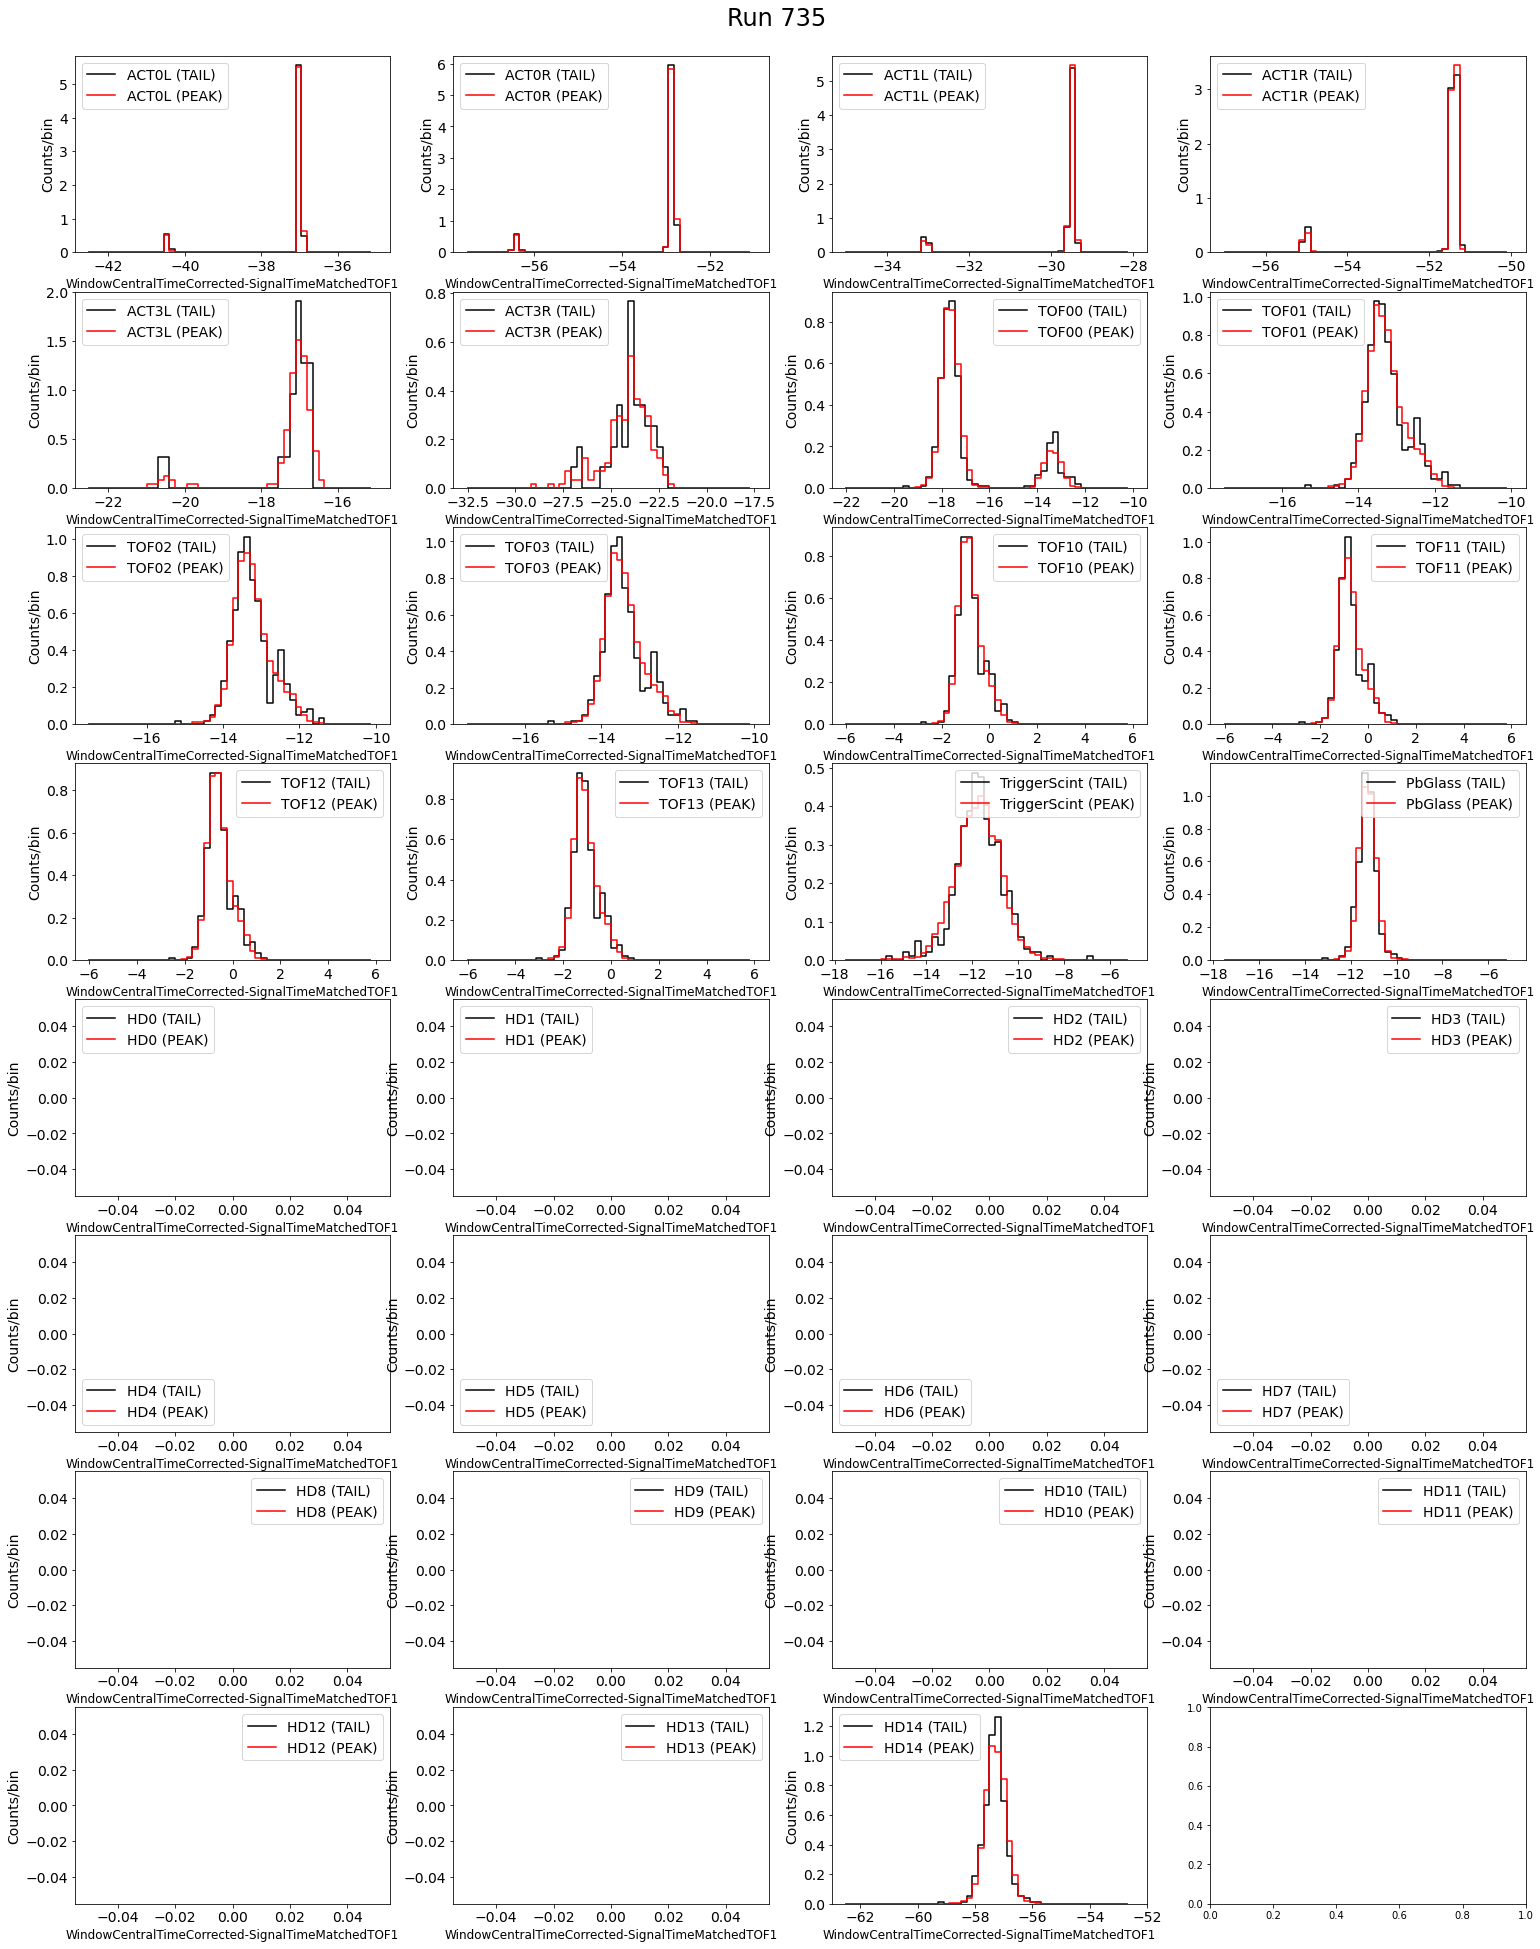

In [20]:
from hodoscope_constants import time_ranges_wide, time_ranges_tight, timing_cuts_wide, timing_cuts_tight

# Select which timing cuts to use
time_ranges = time_ranges_wide
timing_cuts = timing_cuts_wide

# Plot the timing cuts
evt_list = evt_list_TAIL
lbl = 'TAIL'
evt_list_2 = evt_list_PEAK
lbl_2 = 'PEAK'
select_nonzero_peaks = True
windowInt = True
logscale = False
normed = True
nbins = 50

# Create a grid of 8 rows x 4 columns
fig, axes = plt.subplots(8, 4, figsize=(26, 34))
flat_axes = axes.ravel()

fig.suptitle(f'Run {rnum}', fontsize=24, y=0.9)

# Iterate based on the custom order
for key, ax in zip(hd.custom_order, flat_axes):

    # Select the detector.
    df_detector = df_dict[key]
    
    # Apply charge cuts.
    df_detector = df_detector[(df_detector.WindowIntCharge > chg_cuts[key][0]) & (df_detector.WindowIntCharge < chg_cuts[key][1])]
    
    # Cut on the selected events if an event list is provided.
    if(not(evt_list is None)):
        print(f"[{key}] before selection {len(df_select)}")
        
        df_sel_1 = df_detector[df_detector['event'].isin(evt_list)]
        print(f"[{key}] selecting out {len(evt_list)} events to get {len(df_sel_1)}")
        
        if(not(evt_list_2 is None)):
            df_sel_2 = df_detector[df_detector['event'].isin(evt_list_2)]
            print(f"[{key}] selecting out {len(evt_list_2)} events to get {len(df_sel_2)}")
    else:
        df_sel_1 = df_detector
        df_sel_2 = df_detector
    
    # Create the plot
    pk_times_1 = df_sel_1['WindowCentralTimeCorrected'] - df_sel_1['SignalTimeMatchedTOF1']
    hist_1, bin_edges_1 = np.histogram(pk_times_1, bins=nbins, range=time_ranges[key], density=normed)
    bin_centers_1 = (bin_edges_1[:-1] + bin_edges_1[1:]) / 2
    ax.bar(bin_edges_1[:-1], hist_1, width=np.diff(bin_edges_1)[0], align='edge', color='white')
    ax.plot(bin_edges_1[:-1], hist_1, color='black', drawstyle='steps-post', label=f'{key} ({lbl})')
    #print(f"Mean for {key} is {pk_times_1.mean()}: cuts [{pk_times_1.mean()-5:.1f},{pk_times_1.mean()+5:.1f}]")
    #print(f"\'{key}\': [{pk_times_1.mean()-5:.1f},{pk_times_1.mean()+5:.1f}]")
    
    if(not(evt_list_2 is None)):
        pk_times_2 = df_sel_2['WindowCentralTimeCorrected'] - df_sel_2['SignalTimeMatchedTOF1']
        hist_2, bin_edges_2 = np.histogram(pk_times_2, bins=nbins, range=time_ranges[key], density=normed)
        bin_centers_2 = (bin_edges_2[:-1] + bin_edges_2[1:]) / 2
        ax.bar(bin_edges_2[:-1], hist_2, width=np.diff(bin_edges_2)[0], align='edge', color='white')
        ax.plot(bin_edges_2[:-1], hist_2, color='red', drawstyle='steps-post', label=f'{key} ({lbl_2})')
    
    #ax.axvline(timing_cuts[key][0],color='black',linestyle='--')
    #ax.axvline(timing_cuts[key][1],color='black',linestyle='--')
    ax.legend(fontsize=14)

    ax.set_xlabel(f"WindowCentralTimeCorrected-SignalTimeMatchedTOF1",fontsize=12)
    ax.set_ylabel("Counts/bin",fontsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    if(logscale): ax.set_yscale('log')
        
plt.savefig(f"timing.pdf", bbox_inches='tight')

In [12]:
final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.timing_analysis_corrected_winInt(df_dict, chg_cuts, timing_cuts, low_radiation=low_radiation, debug=True)

[Detector ACT0L] events go from 0 to 24949 for total of 24079
[Detector ACT1L] events go from 0 to 24949 for total of 24102
[Detector ACT3R] events go from 0 to 24949 for total of 24855
[Detector TOF01] events go from 0 to 24949 for total of 24074
[Detector HD3] events go from 0 to 24949 for total of 24487
[Detector HD11] events go from 0 to 24949 for total of 24441
[Detector HD10] events go from 0 to 24949 for total of 24452
[Detector HD2] events go from 0 to 24949 for total of 24618
[Detector TOF00] events go from 0 to 24949 for total of 24074
[Detector HD0] events go from 0 to 24949 for total of 24461
[Detector TOF02] events go from 0 to 24949 for total of 24074
[Detector HD12] events go from 0 to 24949 for total of 24509
[Detector HD13] events go from 0 to 24949 for total of 24445
[Detector TOF03] events go from 0 to 24949 for total of 24074
[Detector HD1] events go from 0 to 24949 for total of 24450
[Detector TOF13] events go from 0 to 24949 for total of 24086
[Detector HD5] event

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


--> returning 23743 events
TOF01 filter passed 23995 of 24970 with 540 duplicates
--> returning 23725 events
TOF02 filter passed 23995 of 24970 with 540 duplicates
--> returning 23725 events
TOF03 filter passed 23995 of 24970 with 540 duplicates
--> returning 23725 events
TOF0_combined filter passed 23724 of 23725 with 0 duplicates
--> returning 23724 events

TOF10 filter passed 24016 of 24982 with 544 duplicates
--> returning 23744 events
TOF11 filter passed 24018 of 24983 with 544 duplicates
--> returning 23746 events
TOF12 filter passed 24019 of 24981 with 544 duplicates
--> returning 23747 events
TOF13 filter passed 24011 of 24982 with 540 duplicates
--> returning 23741 events
TOF1_combined filter passed 23729 of 23740 with 0 duplicates
--> returning 23729 events

T2 filter passed 23976 of 24970 with 540 duplicates
--> returning 23706 events
T2 filter passed 23604 of 23706 with 0 duplicates
--> returning 23604 events

ACT0L filter passed 24496 of 24968 with 1734 duplicates
--> retu

### Timing cut table (*tbl.timingcuts*)

In [13]:
# Print timing cut table
cuts_hd14      = (final_df.hit_HD14 == 1)
cuts_hd14_tail = cuts_hd14 & (final_df.LG_WholeWaveformInt <  tail_threshold) #& (final_df.LG_IntCharge > 0.01375)
cuts_hd14_peak = cuts_hd14 & (final_df.LG_WholeWaveformInt >= tail_threshold)

# Total numbers of events 
tot_hd14 = len(final_df[cuts_hd14])
tot_hd14_peak = len(final_df[cuts_hd14_peak])
tot_hd14_tail = len(final_df[cuts_hd14_tail])

# Cuts to evaluate.
cuts_ACT0      = (final_df.hit_ACT0 == 1)
cuts_ACT1      = (final_df.hit_ACT1 == 1)
cuts_ACT3      = (final_df.nohit_ACT3 == 1)
cuts_TOF0      = (final_df.hit_TOF0 == 1)
cuts_TOF1      = (final_df.hit_TOF1 == 1)
cuts_T2        = (final_df.hit_T2 == 1)
cuts_all       = cuts_ACT0 & cuts_ACT1 & cuts_TOF0 & cuts_TOF1 & cuts_T2 # & cuts_ACT3

# Arrays for iterating through the cuts.
cuts_txt = ["HD14 hit only", "ACT0 hit", "ACT1 hit", "ACT3 no hit", "TOF0 hit", "TOF1 hit", "T2 hit", "All"]
cuts_arr = [cuts_hd14, cuts_ACT0, cuts_ACT1, cuts_ACT3, cuts_TOF0, cuts_TOF1, cuts_T2, cuts_all]

print("Cut & All evts (\\%) & Peak evts (\\%) & Tail evts (\\%)\\\\")
print("\hline")
for txt,cuts in zip(cuts_txt,cuts_arr):
    nall  = len(final_df[cuts_hd14 & cuts])
    npeak = len(final_df[cuts_hd14_peak & cuts])
    ntail = len(final_df[cuts_hd14_tail & cuts])
    
    print(f"{txt} & {nall} ({nall/tot_hd14*100:.0f}) & {npeak} ({npeak/tot_hd14_peak*100:.0f}) & {ntail} ({ntail/tot_hd14_tail*100:.0f})\\\\")

Cut & All evts (\%) & Peak evts (\%) & Tail evts (\%)\\
\hline
HD14 hit only & 5230 (100) & 5077 (100) & 153 (100)\\
ACT0 hit & 5092 (97) & 4944 (97) & 148 (97)\\
ACT1 hit & 4685 (90) & 4549 (90) & 136 (89)\\
ACT3 no hit & 0 (0) & 0 (0) & 0 (0)\\
TOF0 hit & 5230 (100) & 5077 (100) & 153 (100)\\
TOF1 hit & 5230 (100) & 5077 (100) & 153 (100)\\
T2 hit & 5227 (100) & 5074 (100) & 153 (100)\\
All & 4560 (87) & 4428 (87) & 132 (86)\\


#### Gamma peaks plot (*fig.gamma_peaks*)

In [ ]:
fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,0.8], timing_cuts=False, low_radiation=False)

#### Timing and charge cuts plot for HD14 (*fig.hd14_cuts*)

NameError: name 'hd_timing_ranges' is not defined

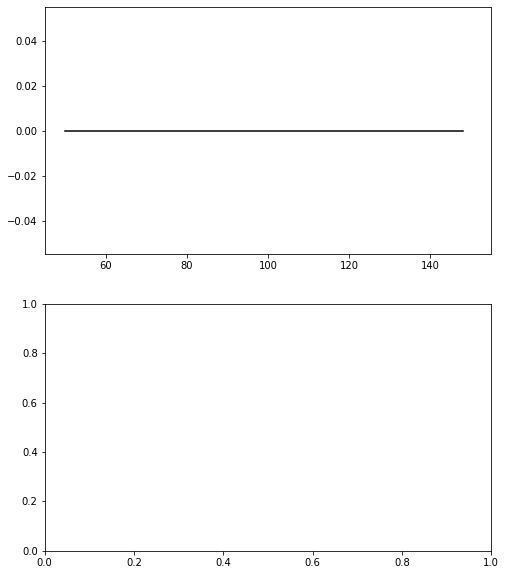

In [14]:
# Plot the timing and charge selections for HD14.

# Set up the figure.
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
flat_axes = axes.ravel()
ax0, ax1 = flat_axes[0], flat_axes[1]

# Select the timing and charge information from the HD14 peaks dataframe.
df_hd14 = df_dict['HD14']
hd14_timing = df_hd14[(df_hd14.PeakTime > 0) & (df_hd14.IntCharge > 0.1)]['PeakTime']
#hd14_timing = df_hd14[df_hd14.PeakTime > 0]['PeakTime']
hd14_charge = df_hd14[df_hd14.IntCharge > 0.02]['IntCharge']

# Plot the timing information with cuts shown.
hist_timing, bin_edges_timing = np.histogram(hd14_timing, bins=50, range=[50,150])
bin_centers_timing = (bin_edges_timing[:-1] + bin_edges_timing[1:]) / 2
ax0.bar(bin_edges_timing[:-1], hist_timing, width=np.diff(bin_edges_timing)[0], align='edge', color='white')
ax0.plot(bin_edges_timing[:-1], hist_timing, color='black', drawstyle='steps-post')
ax0.axvline(hd_timing_ranges['HD14'][0],color='black',linestyle='--')
ax0.axvline(hd_timing_ranges['HD14'][1],color='black',linestyle='--')
ax0.set_xlabel("HD14 Peak Time (samples)",fontsize=14)
ax0.set_ylabel('Counts/bin',fontsize=14)
ax0.tick_params(axis="x", labelsize=14)
ax0.tick_params(axis="y", labelsize=14)

# Plot the charge information with cuts shown.
hist_charge, bin_edges_charge = np.histogram(hd14_charge, bins=50, range=[0,0.6])
bin_centers_charge = (bin_edges_charge[:-1] + bin_edges_charge[1:]) / 2
ax1.bar(bin_edges_charge[:-1], hist_charge, width=np.diff(bin_edges_charge)[0], align='edge', color='white')
ax1.plot(bin_edges_charge[:-1], hist_charge, color='black', drawstyle='steps-post')
ax1.axvline(hd_charge_ranges['HD14'][0],color='black',linestyle='--')
ax1.axvline(hd_charge_ranges['HD14'][1],color='black',linestyle='--')
ax1.set_xlabel("HD14 integrated charge (arbitrary units)",fontsize=14)
ax1.set_ylabel('Counts/bin',fontsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
plt.savefig("HD14_cuts.pdf", bbox_inches='tight')

NameError: name 't2_timing_range' is not defined

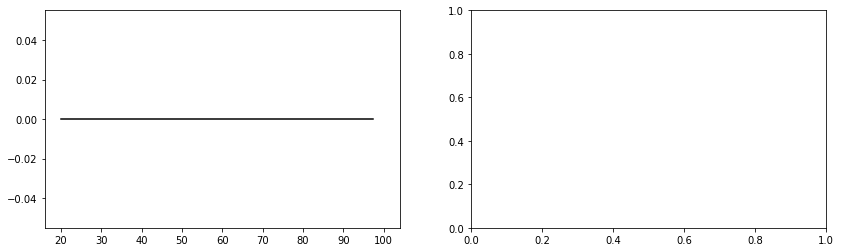

In [15]:
# Plot the timing and charge selections for T2.

# Set up the figure.
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
flat_axes = axes.ravel()
ax0, ax1 = flat_axes[0], flat_axes[1]

# Select the timing and charge information from the HD14 peaks dataframe.
df_T2 = df_dict['TriggerScint']
#T2_timing = df_T2[(df_T2.PeakTime > 0) & (df_T2.IntCharge > 0.0)]['PeakTime']
T2_timing = df_T2[(df_T2.SignalTimeCorrected > 0) & (df_T2.IntCharge > 0.0)]['SignalTimeCorrected']
T2_charge = df_T2[df_T2.IntCharge > 0.0]['IntCharge']

# Plot the timing information with cuts shown.
hist_timing, bin_edges_timing = np.histogram(T2_timing, bins=30, range=[20,100])
bin_centers_timing = (bin_edges_timing[:-1] + bin_edges_timing[1:]) / 2
ax0.bar(bin_edges_timing[:-1], hist_timing, width=np.diff(bin_edges_timing)[0], align='edge', color='white')
ax0.plot(bin_edges_timing[:-1], hist_timing, color='black', drawstyle='steps-post')
ax0.axvline(t2_timing_range[0],color='black',linestyle='--')
ax0.axvline(t2_timing_range[1],color='black',linestyle='--')
ax0.set_xlabel("T2 Peak Time (samples)",fontsize=14)
ax0.set_ylabel('Counts/bin',fontsize=14)
ax0.tick_params(axis="x", labelsize=14)
ax0.tick_params(axis="y", labelsize=14)

# Plot the charge information with cuts shown.
hist_charge, bin_edges_charge = np.histogram(T2_charge, bins=50, range=[0,0.125])
bin_centers_charge = (bin_edges_charge[:-1] + bin_edges_charge[1:]) / 2
ax1.bar(bin_edges_charge[:-1], hist_charge, width=np.diff(bin_edges_charge)[0], align='edge', color='white')
ax1.plot(bin_edges_charge[:-1], hist_charge, color='black', drawstyle='steps-post')
ax1.axvline(t2_charge_range[0],color='black',linestyle='--')
ax1.axvline(t2_charge_range[1],color='black',linestyle='--')
ax1.set_xlabel("T2 integrated charge (arbitrary units)",fontsize=14)
ax1.set_ylabel('Counts/bin',fontsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
plt.savefig("T2_cuts.pdf", bbox_inches='tight')

#### HD14 histogram (*fig.gamma_peak_H14*)

In [16]:
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

Uncalibrated histogram

Initial params: [509, 5.687373452343341, 1.8932050845433828]


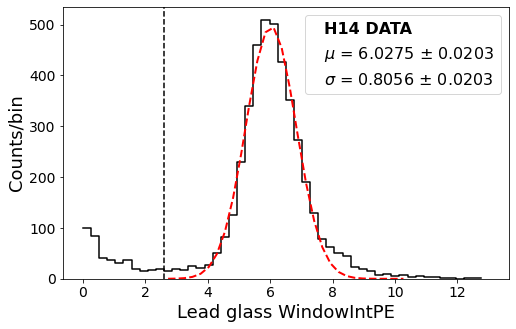

In [17]:
nbins = 50
e_range = [0,13]
fit_start = 10
fit_end = 40
normed = False
cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.total_hits == 1) & (final_df.LG_nWindowPeaks == 1)

# Set up the timing cuts
if(low_radiation):
    cuts_timing = (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
              (final_df.hit_TOF0 == 1) & (final_df.hit_T2 == 1)
else:
    cuts_timing = (final_df.hit_ACT0 == 1) & \
                        (final_df.hit_ACT1 == 1) & \
                        (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)
                        #(final_df.nohit_ACT3 == 1) & \

# Convert the LG charge to energy
#lg_energy = final_df[cuts_nominal & (final_df.hit_TOF0 == 1)]['LG_WindowIntPE']
lg_energy = final_df[cuts_nominal & cuts_timing]['LG_WindowIntPE']
#lg_energy = lg_energy[lg_energy > 50]

# Create the plot
hist, bin_edges = np.histogram(lg_energy, bins=nbins, range=e_range, density=normed)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit
initial_params = [np.max(hist), np.mean(lg_energy), np.std(lg_energy)]
print(f"Initial params: {initial_params}")
popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
perr = np.sqrt(np.diag(pcov))
fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)
        
# Plot the fit peak
fig = plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)
plt.axvline(tail_threshold,color='black',linestyle='--')

# Prepare the legend.
lbl1 = f"H14 DATA"
lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                   Line2D([0], [0], color='none', lw=0, label=lbl2),
                   Line2D([0], [0], color='none', lw=0, label=lbl3)]
leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
for i, text in enumerate(leg.get_texts()):
    if i == 0:
        text.set_weight('bold')
    text.set_horizontalalignment('right')

plt.xlabel("Lead glass WindowIntPE",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)

plt.savefig(f"DATA_gamma_peak_H14.pdf", bbox_inches='tight')
#plt.yscale('log')
#plt.ylim([0.1,np.max(h0[0])*1.5])
#plt.title(f"RUN 000{rnum}, p = + {pbeam/1000} GeV/c",fontsize=20)

Calibrated histogram

In [ ]:
nbins = 50
e_range = [0,700]
fit_start = 15
fit_end = 45
normed = True
cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.total_hits == 1) & (final_df.LG_nPeaks == 1)
ecal_b = -0.017
ecal_m = 6.15e-4

# Set up the timing cuts
if(low_radiation):
    cuts_timing = (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
              (final_df.hit_TOF0 == 1) & (final_df.hit_T2 == 1)
else:
    cuts_timing = (final_df.hit_ACT0 == 1) & \
                        (final_df.hit_ACT1 == 1) & \
                        (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)
                        #(final_df.nohit_ACT3 == 1) & \

# Convert the LG charge to energy
lg_energy = (final_df[cuts_nominal & cuts_timing]['LG_IntCharge'] - ecal_b) / ecal_m
lg_energy = lg_energy[lg_energy > 50]

# Create the plot
hist, bin_edges = np.histogram(lg_energy, bins=nbins, range=e_range, density=normed)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit
initial_params = [np.max(hist), np.mean(lg_energy), np.std(lg_energy)]
print(f"Initial params: {initial_params}")
popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
perr = np.sqrt(np.diag(pcov))
fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)
        
# Plot the fit peak
fig = plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)

# Prepare the legend.
lbl1 = f"H14 DATA"
lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                   Line2D([0], [0], color='none', lw=0, label=lbl2),
                   Line2D([0], [0], color='none', lw=0, label=lbl3)]
leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
for i, text in enumerate(leg.get_texts()):
    if i == 0:
        text.set_weight('bold')
    text.set_horizontalalignment('right')

plt.xlabel("Lead glass energy (MeV)",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)

plt.savefig(f"DATA_gamma_peak_H14.pdf", bbox_inches='tight')
#plt.yscale('log')
#plt.ylim([0.1,np.max(h0[0])*1.5])
#plt.title(f"RUN 000{rnum}, p = + {pbeam/1000} GeV/c",fontsize=20)

#### Plot the timing for the peak and tail events

In [18]:
#df_T1sel
df_peak = final_df[cuts_nominal & cuts_timing & (final_df.LG_WindowIntPE >= tail_threshold)]
evt_list_PEAK = np.array(df_peak.event.values)
df_tail = final_df[cuts_nominal & cuts_timing & (final_df.LG_WindowIntPE < tail_threshold)]
evt_list_TAIL = np.array(df_tail.event.values)
#plt.hist(df_tail['LG_IntCharge'],bins=40)
#peak_T1 = df_peak.merge(df_T1sel, on='event', suffixes=('', '_T1'))
#peak_T1['SignalTimeCorrected_rel'] = peak_T1['SignalTimeCorrected'] - peak_T1['SignalTimeCorrected_T1']

In [ ]:
len(evt_list_PEAK)

#### Select the peak and tail events

In [ ]:
df_hd14 = final_df[cuts_nominal & cuts_timing]
evts_tail = df_hd14[df_hd14['LG_IntCharge'] < 0.1].event
energy_tail = df_hd14[df_hd14['LG_IntCharge'] < 0.1].LG_IntCharge
print("Tail events:",len(evts_tail))
evts_peak = df_hd14[(df_hd14['LG_IntCharge'] >= 0.1) & (df_hd14['LG_IntCharge'] < 0.4)].event
energy_peak = df_hd14[df_hd14['LG_IntCharge'] >= 0.1].LG_IntCharge
print("Peak events:",len(evts_peak))

In [ ]:
print("Peak events")
print(evts_peak.values[0:40])

print("Tail events")
evts_tail.values

In [ ]:
energy_tail.values

In [ ]:
df_PbGlass = df_dict['TOF00']
df_PbGlass[df_PbGlass.event == 165]

In [ ]:
df_dict['HD14']['event'].values

#### Consider the timing difference between the LG and HD14

In [ ]:
# Select the peaks in each detector element for the events in the peak and tail.
df_HD = df_dict['HD14']
df_HD_peak = df_HD[df_HD['event'].isin(evts_peak)]
df_HD_tail = df_HD[df_HD['event'].isin(evts_tail)]
df_LG = df_dict['PbGlass']
df_LG_peak = df_LG[df_LG['event'].isin(evts_peak)]
df_LG_tail = df_LG[df_LG['event'].isin(evts_tail)]

# Handle duplicates in the HD array (rare cases in which we had multiple HD peaks but only 1 made cuts)
u, c = np.unique(df_HD_tail['event'], return_counts=True)
nduplicates = np.sum(c[c > 1])
print(nduplicates,"duplicate events in HD tail")
if(nduplicates > 0): 
    print("Dropping duplicates in HD peak dataframe ...")
    df_HD_peak = df_HD_peak.drop_duplicates(subset=['event'], keep='first')

u, c = np.unique(df_HD_peak['event'], return_counts=True)
nduplicates = np.sum(c[c > 1])
print(np.sum(c[c > 1]),"duplicate events in HD peak")
if(nduplicates > 0): 
    print("Dropping duplicates in HD tail dataframe ...")
    df_HD_tail = df_HD_tail.drop_duplicates(subset=['event'], keep='first')

# Get the tail time differences.
tdiff_tail = []
for evt,t_LG in zip(df_LG_tail['event'].values,df_LG_tail['PeakTime'].values):
    t_HD = df_HD_tail[df_HD_tail['event'] == evt]['PeakTime'].values[0]
    tdiff_tail.append(t_LG - t_HD)

# Get the peak time differences.
tdiff_peak = []
for evt,t_LG in zip(df_LG_peak['event'].values,df_LG_peak['PeakTime'].values):
    t_HD = df_HD_peak[df_HD_peak['event'] == evt]['PeakTime'].values[0]
    tdiff_peak.append(t_LG - t_HD)

In [ ]:
plt.hist(tdiff_tail,bins=40,label="Tail events",alpha=0.6)
plt.hist(tdiff_peak,bins=40,label="Peak events",alpha=0.6)
plt.yscale('log')
plt.xlabel('PeakTime$_{LG}$ - PeakTime$_{HD14}$',fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.legend(fontsize=14)

In [ ]:
_, ct = np.unique(df_HD_peak['event'],return_counts=True)
print("Maximum at",np.argmax(ct))
df_HD_peak[df_HD_peak['event'] == 23243]

#### Plot 2D histograms for the peak and tail events

In [ ]:
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[60,100]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="TOF00", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,90]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="TOF00", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[40,90],[60,190]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="PbGlass", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,120]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="TriggerScint", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=12, range=[[75,125],[160,185]])

hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[60,100]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="TOF00", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,90]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="TOF00", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[40,90],[60,190]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="PbGlass", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,120]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="TriggerScint", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=12, range=[[75,125],[160,185]])

In [ ]:
hd2_events = final_df[(final_df.total_hits == 1) & (final_df.hit_HD2 == 1)]['event'].values

In [ ]:
df_HD14 = df_dict['HD14']
df_HD14[df_HD14['event'].isin(hd2_events)].head()

In [ ]:
df_HD2 = df_dict['HD2']
df_HD2_inpeak = df_HD2[df_HD2['event'].isin(evts_peak)]
plt.hist(df_HD2_inpeak[df_HD2_inpeak.IntCharge > 0.01].IntCharge,bins=50)

In [ ]:
# Plot the tail events control plots
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

# Plot the peak events control plots
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

#### Show the effects of the ACT and TOF cuts

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_ACT0 = cuts_all #& (final_df.hit_ACT0 == 1)
cuts_ACT1 = cuts_ACT0 & (final_df.hit_ACT1 == 1)
cuts_ACT3 = cuts_ACT1 & (final_df.nohit_ACT3 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['LG_IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT0]['LG_IntCharge'],bins=40,label="HD14+ACT0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT1]['LG_IntCharge'],bins=40,label="HD14+ACT0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT3]['LG_IntCharge'],bins=40,label="HD14+ACT0/1/3")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title(f"RUN 000{rnum}, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_ACT0 = cuts_all #& (final_df.hit_ACT0 == 1)
cuts_ACT1 = cuts_ACT0 & (final_df.hit_ACT1 == 1)
cuts_ACT3 = cuts_ACT1 & (final_df.nohit_ACT3 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['LG_IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT0]['LG_IntCharge'],bins=40,label="HD14+ACT0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT1]['LG_IntCharge'],bins=40,label="HD14+ACT0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT3]['LG_IntCharge'],bins=40,label="HD14+ACT0/1/3")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title(f"RUN 000{rnum}, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

#### Count the number of events in the tails

In [ ]:
cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.total_hits == 1) & (final_df.LG_nPeaks == 1)
if(low_radiation):
    cuts_timing = (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
              (final_df.hit_TOF0 == 1) & (final_df.hit_T2 == 1)
else:
    cuts_timing = (final_df.hit_ACT0 == 1) & \
                        (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
                        (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)
normed=False
    
values_hd14 = final_df[cuts_nominal & cuts_timing]['LG_IntCharge']

ntail = len(values_hd14[values_hd14 < 0.1])
npeak = len(values_hd14[values_hd14 >= 0.1])
ftail = ntail/(npeak+ntail)
fpeak = npeak/(npeak+ntail)
print("Number of counts < 0.1:",ntail)
print("Number of counts >= 0.1:",npeak)
print("Ratio of tail/total events:",ftail)
print("Ratio of peak/total events:",fpeak)

fig = plt.figure(figsize=(14,7))
h0 = plt.hist(values_hd14,bins=80,label="HD14",range=[0,0.5],density=normed)
plt.xlabel("Lead glass charge",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.title(f"RUN 000{rnum}, p = + 0.8 GeV/c;\n{ntail} tail events < 0.1 ({ftail*100:.2f}%), {npeak} peak events >= 0.1 ({fpeak*100:.2f}%)",fontsize=20)
plt.legend(fontsize=18)

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_TOF0 = cuts_all & (final_df.hit_TOF0 == 1)
cuts_TOF1 = cuts_TOF0 & (final_df.hit_TOF1 == 1)
cuts_T2 = cuts_TOF1 & (final_df.hit_T2 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['LG_IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF0]['LG_IntCharge'],bins=40,label="HD14+TOF0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF1]['LG_IntCharge'],bins=40,label="HD14+TOF0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_T2]['LG_IntCharge'],bins=40,label="HD14+TOF0/1/2")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

In [ ]:
#plt.hist(df_dict['ACT3L'][df_dict['ACT3L']['PeakTime'] > 10]['PeakTime'],bins=100)
plt.hist(df_dict['ACT1L'][df_dict['ACT1L']['PeakTime'] > 10]['PeakTime'],bins=100)
#plt.hist(act0_combined['combined_charge'],bins=100)

In [ ]:
plt.hist(tof1_combined['combined_charge'],bins=100,range=[0,1])
#plt.hist(df_dict['TOF00']['PeakTime'],bins=100,range=[35,90])
#plt.hist(df_dict['TriggerScint']['IntCharge'],bins=100,range=[0,0.05])

In [ ]:
events = uproot.open("{}".format("../ntuples/ntuple_000734.root"))
main_keys = events.keys()

In [ ]:
dataframes

# 2. Plots of magnetic field map

In [ ]:
# Read the field map.
df = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', header=None)

# Assign column names
df.columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']

# Compute the magnitude of the field
df['Bmag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)

df.head(20)

In [ ]:
len(df['y'].unique())

#### 1D plot (*fig.fieldmap*)

In [ ]:
df_center = df[(df['y'] == 0) & (df['x'] == 0)]
df_r1 = df[(df['y'] == 0) & (df['x'] == 15.0)]

# Central axis
By_center = df_center['By'].values
z_center  = df_center['z'].values

# Off-axis near smallest bore edge
By_r1 = df_r1['By'].values
z_r1  = df_r1['z'].values

plt.figure(figsize=(8,5))
plt.plot(z_center,By_center,linewidth=1,color='black',label="B$_y$ (r = 0 mm)")
plt.plot(z_r1,By_r1,linewidth=1,color='black',linestyle='--',label="B$_y$ (r = 15 mm)")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{y}$ (T)',fontsize=14)
plt.legend(fontsize=17,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

In [ ]:
print(z_center[By_center < -1.35])

In [ ]:
df_filtered = df[(df['y'] == 0) & (df['x'] == 0)]
Bx = df_filtered['Bx'].values
By = df_filtered['By'].values
Bz = df_filtered['Bz'].values
z  = df_filtered['z'].values

plt.figure(figsize=(10,6))
plt.plot(z,Bx,linewidth=2,color='red', label="B$_x$")
plt.plot(z,By,linewidth=2,color='black', label="B$_y$")
plt.plot(z,Bz,linewidth=2,color='blue', label="B$_z$")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{x,y,z}$ (T)',fontsize=14)
plt.legend(fontsize=18,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

In [ ]:
Bd = np.trapz(z_center,By_center)/1000
print(f"Integrated field By = {Bd} T*m")

In [ ]:
# Geant4 field
z = np.linspace(-500,500,100)
fwhm_to_sigma = (2*(2*np.log(2))**0.5)
sigma = 150 / fwhm_to_sigma
bfield = -1.441*np.exp(-z**2/(2*sigma**2))
plt.plot(z,bfield)
plt.ylabel("B$_y$ (T)",fontsize=16)
plt.xlabel("z (mm)",fontsize=16)
#print(f"FWHM to sigma conversion factor: {fwhm_to_sigma}")

In [ ]:
Bd_sim = np.trapz(z,bfield)/1000
print(f"Integrated field simulated in Geant4 = {Bd_sim} T*m")

#### 2D plots

In [ ]:
# Filter dataframe for a specific y-plane, for example, y=0
y_plane = 0
#df_filtered = df[(df['y'] == y_plane) & (df['z'] > -100) & (df['z'] < 250)]
df_filtered = df[df['y'] == y_plane]

# Create a pivot table for the magnitude values
pivot = df_filtered.pivot(index='x', columns='z', values='Bmag').fillna(0)

# Create the heatmap
plt.figure(figsize=(10,6))
plt.imshow(pivot, aspect='auto', cmap='viridis', origin='lower', 
           extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()])
plt.colorbar(label='Field Magnitude (T)')
plt.title(f'Magnetic Field Magnitude in x-z plane at Y={y_plane}')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')
plt.show()

In [ ]:
# Filter dataframe for a specific z-plane, e.g., z=0
z_plane = 75
df_filtered = df[df['z'] == z_plane]
arrow_scale = 1

# Create the quiver (arrow) plot
plt.figure(figsize=(12,8))
plt.quiver(df_filtered['x'], df_filtered['y'], arrow_scale*df_filtered['Bx'], arrow_scale*df_filtered['By'], 
           angles='xy', scale_units='xy', scale=1, color='blue', width=0.002)
plt.title(f'Magnetic Field Direction in x-y plane at Z={z_plane}')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.axis('equal')
plt.show()


### Extend the magnetic field

In [ ]:
data = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', 
                   header=None, names=['X', 'Y', 'Z', 'Bx', 'By', 'Bz'])

# Generate additional points
new_points_range = np.arange(-40, 40.1, 2.5)  # Including +/- 40 mm with a step size of 2.5 mm

# Initialize a list to collect new rows
new_rows = []

# Magnet radii
r1 = 30  # mm; bore radius 1 = 23
r2 = 40  # mm; bore radius 2 = 31
r3 = 45  # mm; bore radius 3 = 40
deltaZ = 50 # mm; length of one magnet segment (3 in total)

ipt = 0
zpoints = data['Z'].unique()
npts = len(zpoints)*len(new_points_range)**2
for z in zpoints:
    # Find the set of existing X and Y for this Z to avoid duplicates
    existing_xy = data[data['Z'] == z][['X', 'Y']].drop_duplicates()

    for x in new_points_range:
        for y in new_points_range:
            # Check if this X, Y combination is new
            if not ((existing_xy['X'] == x) & (existing_xy['Y'] == y)).any():
                # Find the closest existing point in the original data for this Z
                # Using Euclidean distance for simplicity; this could be adjusted as needed
                distances = np.sqrt((data['X'] - x)**2 + (data['Y'] - y)**2 + (data['Z'] - z)**2)
                closest_index = distances.idxmin()
                closest_point = data.loc[closest_index]
                
                # Ensure the field is within the allowed region.
                isInside = False
                r = (x**2 + y**2)**0.5
                if (z <= 0                         and r <= r1): isInside = True  # pre-magnet
                if (z > 0        and z < deltaZ    and r <= r1): isInside = True  # region 1
                if (z > deltaZ   and z <= 2*deltaZ and r <= r2): isInside = True  # region 2
                if (z > 2*deltaZ and z <= 3*deltaZ and r <= r3): isInside = True  # region 3
                if (z > 3*deltaZ                   and r <= r3): isInside = True  # post-magnet
                
                # Set the field.
                if(isInside):
                    Bx = closest_point['Bx']
                    By = closest_point['By']
                    Bz = closest_point['Bz']
                    #print(f"Adding field {Bx},{By},{Bz} at ({x},{y},{z}) with closest point {closest_point['X']},{closest_point['X']},{closest_point['X']}")
                else:
                    Bx = 0
                    By = 0
                    Bz = 0

                # Create a new row with this X, Y, Z and the Bx, By, Bz from the closest point
                new_row = {'X': x, 'Y': y, 'Z': z, 'Bx': Bx, 'By': By, 'Bz': Bz}
                new_rows.append(new_row)
                
            ipt += 1
            if(ipt % 1000 == 0):
                print(f"[pt {ipt}] of possible {npts} ({ipt/npts*100:.1f})%")

# Convert the list of new rows to a DataFrame
print("Creating new dataframe...")
new_points_df = pd.DataFrame(new_rows)

# Combine with the original data and sort
print("Sorting...")
combined_data = pd.concat([data, new_points_df], ignore_index=True)
combined_data = combined_data.sort_values(by=['Z', 'Y', 'X'], ascending=[True, True, True])

# Save to a new file
print("Saving...")
extrapolated_file_path = 'mfMapMeasured_extrapolated.txt'
combined_data.to_csv(extrapolated_file_path, sep='\t', index=False, header=False)

In [ ]:
len(data['Z'].unique())*len(new_points_range)**2

In [ ]:
len(new_points_range)

In [ ]:
13*13*320

In [ ]:
new_points_df

# 3. Waveform analysis (*fig.waveform*)

In [ ]:
import json5
import sys
sys.path.append("..")
import waveform_analysis as wf

In [ ]:
# Open the run file and config file.
run_file = uproot.open("root_run_000735.root")
config = json5.load(open("../../../config/config_hodoscope.json"))['WaveAnalysis']

# Load the waveforms for HD14.
waveforms_HD14 = run_file['midas_data_D302']['Channel7'].array().to_numpy()

# Run the analysis of the waveforms.
analysis = wf.WaveformAnalysis(waveforms_HD14,
                            threshold=config["Thresholds"][0],
                            analysis_window=(config["AnalysisWindowLow"][0], config["AnalysisWindowHigh"][0]),
                            pedestal_window=(config["PedestalWindowLow"][0], config["PedestalWindowHigh"][0]),
                            reverse_polarity=(config["Polarity"][0]==0),
                            voltage_scale=config["VoltageScale"],
                            time_offset=config["TimeOffset"][0])
analysis.find_all_peak_voltages()

In [ ]:
evt = 20675
base_dir = "plt_waveforms"

fig, axs = plt.subplots(1, 1, figsize=(7,4))
fig.tight_layout()
axs.plot(waveforms_HD14[evt][0:220],color='black')
#plt.title(f"")

# Iterate over peak times and plot arrows
for peak in analysis.pulse_peak_times[evt]:

    # Divide out the 2 ns / sample.
    peak_sample = int(peak/2)
    
    # Get the corresponding ADC count for the peak time
    y_peak = waveforms_HD14[evt][int(peak/2)]
    
    # Plot the arrow. The -5 in dy is arbitrary and used to offset the arrow tip for visibility.
    axs.arrow(peak_sample, y_peak-400, 0, 15, head_width=5, head_length=250, fc='red', ec='red')

axs.grid(alpha=0.4)
axs.set_xlabel("Sample (2 ns)",fontsize=14)
axs.set_ylabel("ADC counts",fontsize=14)
axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)

# Label the different regions
axs.axvspan(0, 100, color='red', alpha=0.1)
axs.axvspan(150, 210, color='lightblue', alpha=0.5)
axs.text(20, 8500, 'Analysis', ha='center', va='top', fontsize=12, fontweight='bold', color='black')
axs.text(170, 8500, 'Pedestal', ha='center', va='top', fontsize=12, fontweight='bold', color='black')

out_dir = f"{base_dir}/HD14"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
plt.savefig(f"{out_dir}/wf_HD14_{evt}.pdf", bbox_inches='tight')
#plt.close()

# 4. Data processing

### Create dataframes for all runs

In [ ]:
ntuple_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple/"
ntuple_pd_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple_dataframes/"
windowInt = True

In [ ]:
#runs = np.arange(630,766)
runs = [735]
for run in runs:
    ntuple_file = "{}/WindowIntMatched_final_000735.root".format(ntuple_dir,run)
    #ntuple_file = "{}/peakAnalysed_timeCorr_000735.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = hd.ntuple_to_pd_multipeak(ntuple_file,windowInt=windowInt)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

### Plot all quantities for each signal for each run

In [ ]:
runs = [735] #np.arange(786,788)
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', windowInt=windowInt, select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', windowInt=windowInt, select_nonzero_peaks=False, logscale=True, nbins=60)
    
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='MaxVoltage', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WholeWaveformInt', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WholeWaveformIntPE', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    
    if(windowInt):
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nWindowPeaks', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeMatchedTOF0', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeMatchedTOF1', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowIntCharge', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowIntPE', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowWidth', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowLowerTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowUpperTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowCentralTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowCentralTimeCorrected', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
    else:
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=20)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=40)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeCorrected', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntPE', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)

## Compute and plot statistics for each run

In [ ]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = hd.compute_statistics(df_dict[key])

#### Plot summary statistics from each run

In [ ]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

hd.plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

---

# OLD CODE

## Single-peak analysis

In [ ]:
# Timing and charge ranges for filters.
pb_timing_range = (45, 75)
tof0_timing_range = (45, 85)
tof0_charge_range = (0.3, 1.0)
tof1_timing_range = (60, 100)
tof1_charge_range = (0.3, 1.0)
t2_timing_range = (160, 180)
t2_charge_range = (0.01, 0.0225)
act0_timing_range = (130, 175)
act0_charge_range = (0.1, 1.0)
act1_timing_range = (130, 175)
act1_charge_range = (0.02, 0.2)
act3_timing_range = (150, 190)
hd_timing_ranges = {
    'HD0': (35, 75),
    'HD1': (35, 75),
    'HD2': (35, 75),
    'HD3': (35, 75),
    'HD4': (35, 75),
    'HD5': (35, 75),
    'HD6': (35, 75),
    'HD7': (35, 75),
    'HD8': (80, 120),
    'HD9': (80, 120),
    'HD10': (80, 120),
    'HD11': (80, 120),
    'HD12': (80, 120),
    'HD13': (80, 120),
    'HD14': (80, 120)
}
hd_charge_ranges = {
    'HD0': (0.12, 0.3),
    'HD1': (0.09, 0.2),
    'HD2': (0.06, 0.15),
    'HD3': (0.075, 0.2),
    'HD4': (0.075, 0.2),
    'HD5': (0.1, 0.3),
    'HD6': (0.1, 0.3),
    'HD7': (0.1, 0.3),
    'HD8': (0.085, 0.285),
    'HD9': (0.085, 0.285),
    'HD10': (0.1, 0.3),
    'HD11': (0.075, 0.275),
    'HD12': (0.1, 0.3),
    'HD13': (0.1, 0.4),
    'HD14': (0.1, 0.4)    
}